In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Datasets import load
from torch.utils.data import DataLoader
from model import Conv_Net_Dropout
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np

In [4]:
model = Conv_Net_Dropout()
model.load_state_dict(torch.load('/home/julius/OOD/models/model2_drop.pth'))
model.to('cuda')
model.train()

Conv_Net_Dropout(
  (convs): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
  )
  (fcs): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)

## MNIST

In [5]:
mnist = load('MNIST')(train=False)
mnist_loader = DataLoader(mnist, batch_size=1, shuffle=True)
d = {}
for i in range(10):
    d[i] = []
mnist_uncertainty = []
with torch.no_grad():
    for x,y in tqdm(mnist):
        x = x.repeat_interleave(128, dim=0)[:,None]
        x = x.to('cuda')
        out = model(x).cpu()
        mnist_uncertainty.append(out.std(dim=0).mean().item())
        d[y].append(out.std(dim=0).mean())


100%|██████████| 10000/10000 [00:12<00:00, 793.49it/s]


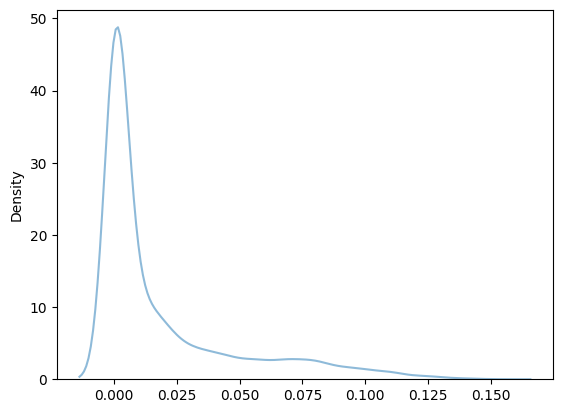

In [6]:
mnist_uncertainty = torch.tensor(mnist_uncertainty)
sns.kdeplot(mnist_uncertainty, alpha=0.5, label='MNIST')
plt.show()

In [7]:
mnist_df = pd.DataFrame()
for key in d.keys():
    df = pd.DataFrame({'Uncertainty': np.array(d[key]),'Class':np.repeat(key,len(d[key])).astype(str)})
    mnist_df = pd.concat([mnist_df, df], ignore_index=True)

<Axes: xlabel='Uncertainty', ylabel='Density'>

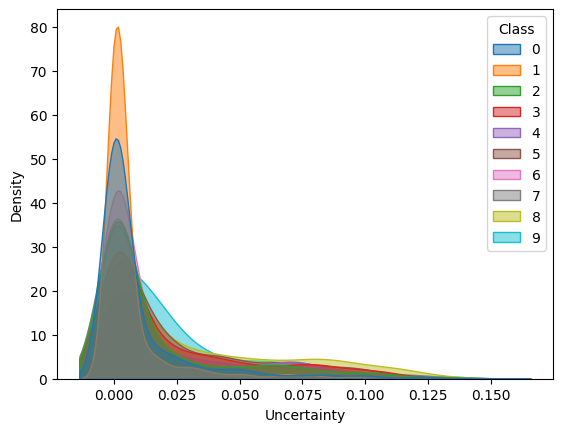

In [8]:
sns.kdeplot(data=mnist_df,x = 'Uncertainty', hue='Class', fill=True, common_norm=False, common_grid=True, alpha=0.5)

## CIFAR10

In [9]:
cifar10 = load('CIFAR10')(train=False)
cifar10_uncertainty = []
with torch.no_grad():
    for x,y in tqdm(cifar10):
        x = x.repeat_interleave(128, dim=0)[:,None]
        x = x.to('cuda')
        out = model(x).cpu()
        cifar10_uncertainty.append(out.std(dim=0).mean().item())

Files already downloaded and verified


100%|██████████| 10000/10000 [00:16<00:00, 604.85it/s]


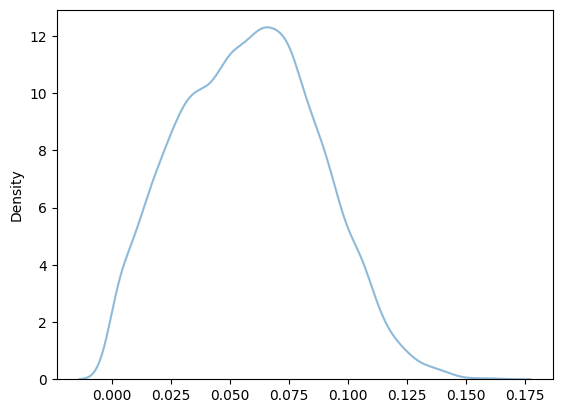

In [10]:
cifar10_uncertainty = torch.tensor(cifar10_uncertainty).clone().detach()
sns.kdeplot(cifar10_uncertainty,  alpha=0.5, label='CIFAR10')
plt.show()

## Compared

In [11]:
print('CIFAR10 mean uncertainty:', cifar10_uncertainty.mean().item())
print('MNIST mean uncertainty:', mnist_uncertainty.mean().item())

CIFAR10 mean uncertainty: 0.05800921469926834
MNIST mean uncertainty: 0.018667785450816154


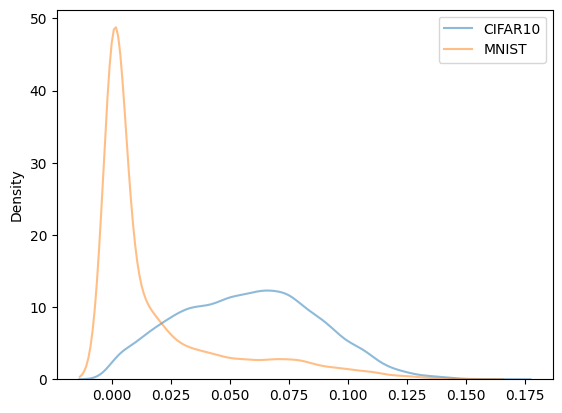

In [12]:
sns.kdeplot(cifar10_uncertainty,alpha=0.5, label='CIFAR10')
sns.kdeplot(mnist_uncertainty,alpha=0.5, label='MNIST')
plt.legend()
plt.show()

In [13]:
mnist_uncertainty.shape, cifar10_uncertainty.shape

(torch.Size([10000]), torch.Size([10000]))

In [14]:
# statistical test for comparing the two distributions
statistic, p_value = ttest_ind(mnist_uncertainty, cifar10_uncertainty)

print("Statistic:", statistic)
print("P-value:", p_value)



Statistic: -95.70196625468928
P-value: 0.0
